In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam

In [22]:
data = pd.read_csv('encoded_normalized_data.csv')
data

,sourceID,BodyGroup_from,BodyGroup_to,timediff,SN
0,10.0,1,1,0.379099,182625
1,11.0,1,1,0.305271,182625
2,4.0,1,1,0.358655,182625
3,5.0,1,1,0.576982,182625
4,6.0,1,1,0.273011,182625
...,...,...,...,...,...
1151,7.0,6,6,0.000000,182625
1152,4.0,6,6,0.000000,182625
1153,5.0,6,6,0.000000,182625
1154,12.0,6,6,0.000000,182625


In [23]:
# Prepare the input (X) and output (y) data
X = data[['sourceID', 'BodyGroup_from', 'BodyGroup_to']].values
y = data['timediff'].values

# Reshape X for LSTM input (samples, time steps(that we are looking back), features)
X = X.reshape((X.shape[0], 1, X.shape[1]))

print("\nShape of X:", X.shape) 
print("Shape of y:", y.shape)    

original_indices = data.index  # Save the original indices

# Split the data into train and temporary sets (60% train, 40% temp)
X_train, X_temp, y_train, y_temp, train_indices, temp_indices = train_test_split(
    X, y, original_indices, test_size=0.4, random_state=42)

# Further split the temporary set into validation and test sets (15% val, 25% test)
X_val, X_test, y_val, y_test, val_indices, test_indices = train_test_split(
    X_temp, y_temp, temp_indices, test_size=0.625, random_state=42)

# Display shapes of the split datasets
print("\nTraining set shape (X_train, y_train):", X_train.shape, y_train.shape)
print("Validation set shape (X_val, y_val):", X_val.shape, y_val.shape)
print("Test set shape (X_test, y_test):", X_test.shape, y_test.shape)

print("Length of train_indices:", len(train_indices))
print("Length of temp_indices:", len(temp_indices))
print("Length of val_indices:", len(val_indices))
print("Length of test_indices:", len(test_indices))


Shape of X: (1156, 1, 3)
Shape of y: (1156,)

Training set shape (X_train, y_train): (693, 1, 3) (693,)
Validation set shape (X_val, y_val): (173, 1, 3) (173,)
Test set shape (X_test, y_test): (290, 1, 3) (290,)
Length of train_indices: 693
Length of temp_indices: 463
Length of val_indices: 173
Length of test_indices: 290


In [24]:

# LSTM model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50, activation='relu', return_sequences=True),
    Dropout(0.2),  # Dropout layer with 20% dropout rate
    LSTM(30, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    verbose=1
)


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.2236 - val_loss: 0.1678
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1746 - val_loss: 0.1406
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1526 - val_loss: 0.1215
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1305 - val_loss: 0.1068
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1197 - val_loss: 0.0961
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1095 - val_loss: 0.0899
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1040 - val_loss: 0.0848
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1040 - val_loss: 0.0828
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0974 - val_loss: 0.0811
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0937 - val_loss: 0.0799
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0900 - val_loss: 0.0792
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1008 - val_l

In [25]:
# Evaluate on the Test Set
test_loss = model.evaluate(X_test, y_test)
print(f"\nTest Loss: {test_loss}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0709

Test Loss: 0.0699075311422348


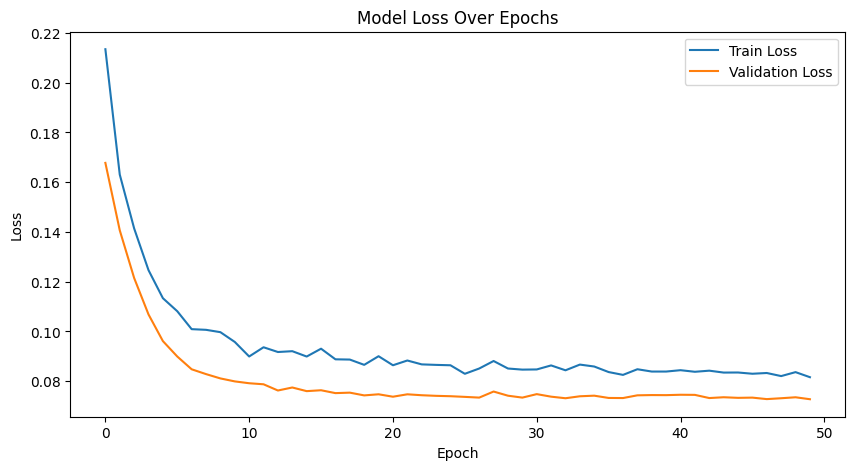

In [26]:
# Visualize Training and Validation Loss Over Epochs
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


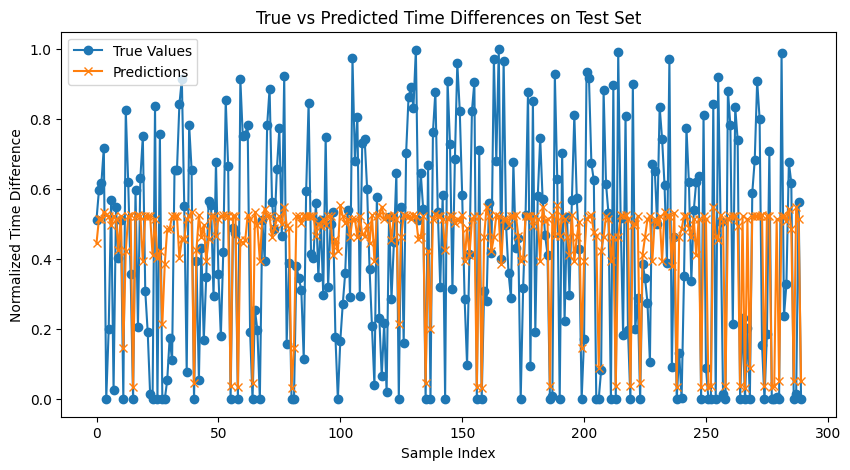

In [27]:
# Make Predictions on the Test Set
predictions = model.predict(X_test)

# Plot true vs. predicted values (for the normalized data)
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='True Values', marker='o')
plt.plot(predictions.flatten(), label='Predictions', marker='x')
plt.title('True vs Predicted Time Differences on Test Set')
plt.xlabel('Sample Index')
plt.ylabel('Normalized Time Difference')
plt.legend()
plt.show()


In [28]:

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(data[['timediff']]) 

predictions = np.random.rand(len(X_test)) 

# Denormalize the predictions
predictions_denormalized = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
filtered_data = data.iloc[test_indices].reset_index(drop=True)
output_path = "dataset_denormalized_predictions.csv"
filtered_data.to_csv(output_path, index=False)
print("Denormalized predictions saved successfully!")

# Check if predictions length matches filtered data length
if len(predictions_denormalized) == len(filtered_data):

    filtered_data['Predicted Values'] = predictions_denormalized

    # Save the updated dataset to a CSV file
    output_path = "dataset_normalized_predictions.csv"
    filtered_data.to_csv(output_path, index=False)

    # Display a few rows to confirm
    print("First few rows of the dataset with denormalized predictions:")
    print(filtered_data.head())
else:
    print("Length mismatch between predictions and filtered data. Check your dataset and predictions alignment.")
    
print("Length of predictions:", len(predictions_denormalized))
print("Length of filtered data:", len(filtered_data))

Denormalized predictions saved successfully!
First few rows of the dataset with denormalized predictions:
   sourceID  BodyGroup_from  BodyGroup_to  timediff      SN  Predicted Values
0       1.0               3             3  0.513398  182625          0.543091
1       1.0               1             1  0.597400  182625          0.141423
2       1.0               1             1  0.617272  182625          0.165457
3       1.0               1             3  0.718921  182625          0.736435
4       4.0               1             1  0.001654  182625          0.799141
Length of predictions: 290
Length of filtered data: 290


In [29]:
#Eavulate Model Performance metrices
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test_denormalized, predictions_denormalized)
mse = mean_squared_error(y_test_denormalized, predictions_denormalized)
r2 = r2_score(y_test_denormalized, predictions_denormalized)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-Squared (R²): {r2}")

NameError: name 'y_test_denormalized' is not defined

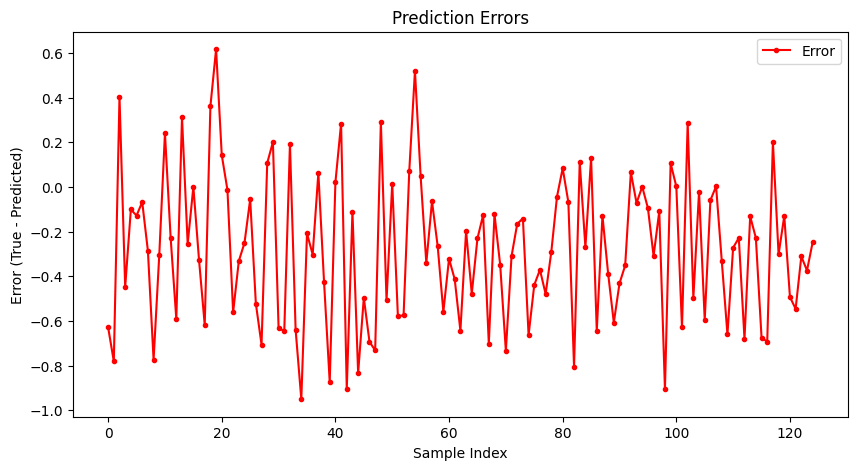

In [13]:
#Plot Error metrices
errors = y_test_denormalized - predictions_denormalized

plt.figure(figsize=(10, 5))
plt.plot(errors, label='Error', color='red', marker='.')
plt.title('Prediction Errors')
plt.xlabel('Sample Index')
plt.ylabel('Error (True - Predicted)')
plt.legend()
plt.show()

In [ ]:

predicted_values = predictions_denormalized.flatten() 

# Print all predicted values
print("Predicted Values:")
print(predicted_values)


print("\nFirst 10 Predicted Values:")
print(predicted_values[:10])

Predicted Values:
[0.74372325 0.905151   0.0560107  0.48836804 0.20539582 0.14675077
 0.19771439 0.28607433 0.9384559  0.55036458 0.09149159 0.25231308
 0.8356951  0.02517198 0.36378594 0.25790866 0.41875044 0.70616512
 0.12020876 0.37550991 0.81075087 0.05310481 0.57726812 0.45013086
 0.25628286 0.0919189  0.63508933 0.79492961 0.82182962 0.02169155
 0.96184237 0.68324341 0.02732641 0.81779426 0.99687121 0.38412181
 0.52555725 0.306823   0.46266976 0.92080933 0.03645839 0.19214839
 0.90486719 0.3538193  0.94159225 0.72153116 0.88063397 0.80995655
 0.18498687 0.74980369 0.02141755 0.77570253 0.76884655 0.06834407
 0.44441075 0.06054676 0.39388007 0.10393457 0.78638286 0.61909634
 0.45117409 0.58805207 0.68442124 0.25818348 0.6545625  0.24590272
 0.61627831 0.75738077 0.18894689 0.42119922 0.9923802  0.47960486
 0.5565034  0.6179425  0.84548916 0.80868471 0.56349008 0.51023638
 0.52414802 0.10936675 0.2473815  0.19891195 0.80457233 0.00543707
 0.6022011  0.34476783 0.70835826 0.23779936

In [15]:
# Save predictions to a DataFrame
predicted_df = pd.DataFrame(predicted_values, columns=['Predicted Values'])

# Save to CSV
predicted_df.to_csv('predicted_values.csv', index=False)
print("Predicted values saved to 'predicted_values.csv'")

Predicted values saved to 'predicted_values.csv'
